# Compare phenotypes from DMS (or some other source) to natural sequence evolution
The basic approach is to find all pairs of parent-descendant Pango clades that differ by at least one single spike amino-acid substitution, and then compare the differences in growth rates to changes in spike phenotypes measured by DMS (or some other method).

This approach of comparing clade pairs is better than trying to compare all clades based on their phenotypes as it avoids phylogenetic correlations because it only utilizes the new mutation that has appeared in each parent / descendant clade pair rather than all mutations in clades (the latter approach is confounded by phylogeny due to clades sharing mutations by ancestry).

We compute P-values by comparing the actual correlations to those generated by randomizing the DMS (or other phenotypic) data among mutations.

Note that at the end we also plot absolute predicted growth rate and phenotypes for all clades, but do not perform regression on those due to phylogenetic issues noted above.

In [1]:
# this cell is tagged parameters for papermill parameterization
starting_clades = None  # keep all Pango clades descended from clades in this list
exclude_muts = None  # exclude clade pairs containing new mutations, and clades containing mutation relative to dms clade in this list
min_sequences = None  # only keep clades with at least this many sequences
split_by_rbd = None  # analyze RBD and non-RBD mutations separately, requires "region" column in input data
dms_clade = None  # starting DMS clade
pair_min_spike_muts = None  # only keep pairs with at least this many mutations (typically 1)
pair_max_spike_muts = None  # only keep pairs with <= this many mutations, use None for no limit
pair_only_new_muts_are_spike = None  # only keep clade pairs where the only new amino-acid mutations are in spike
n_random = None  # number of randomizations for P-values
rename_cols = None  # dict specifying how to rename columns in input data
title = None  # title for approach used to measure phenotypes
phenotype_basic_colors = None  # dict mapping phenotypes (not split by RBD) to colors
missing_muts = None  # "drop" clades with missing mutations, or set missing mutations to "zero"
exclude_clades = None  # exclude these clades, or empty list
growth_rates_csv = None  # input growth rate data
input_data = None  # CSV with input DMS data
pango_consensus_seqs_json = None  # JSON with Pango sequences for each clade
pair_growth_dms_csv = None  # output file with changes in growth versus changes in phenotypes for all clade pairs
clade_growth_dms_csv = None  # output file with growth and phenotypes for clades\
pair_corr_html = None  # output plot
clade_corr_html = None  # output plot
pair_ols_html = None  # output plot

In [2]:
# Parameters
starting_clades = ["XBB"]
exclude_muts = []
min_sequences = 400
split_by_rbd = False
dms_clade = "XBB.1.5"
pair_min_spike_muts = 1
pair_max_spike_muts = None
n_random = 2
rename_cols = {"human sera escape": "sera escape", "spike mediated entry": "cell entry"}
title = "XBB.1.5 full-spike DMS phenotypes"
phenotype_basic_colors = {
    "sera escape": "red",
    "ACE2 binding": "blue",
    "cell entry": "purple",
}
missing_muts = "drop"
exclude_clades = []
growth_rates_csv = "MultinomialLogisticGrowth/model_fits/rates.csv"
input_data = "results/summaries/summary.csv"
pango_consensus_seqs_json = (
    "results/compare_natural/pango-consensus-sequences_summary.json"
)
pair_growth_dms_csv = "results/compare_natural/current_dms_clade_pair_growth.csv"
clade_growth_dms_csv = "results/compare_natural/current_dms_clade_growth.csv"
pair_corr_html = "results/compare_natural/current_dms_clade_pair_growth.html"
clade_corr_html = "results/compare_natural/current_dms_clade_growth.html"
pair_ols_html = "results/compare_natural/current_dms_ols_clade_pair_growth.html"

import os
os.chdir("../")

In [28]:
import collections
import copy
import datetime
import functools
import itertools
import json
import math
import operator
import re
import tempfile

import altair as alt

import baltic

import Bio.Phylo

import dmslogo.colorschemes

import matplotlib
import matplotlib.pyplot as plt

import numpy

import pandas as pd

import polyclonal.plot

import scipy.stats

import statsmodels.api

_ = alt.data_transformers.disable_max_rows()

## Read Pango clades and identify all pairs and the separating spike mutations
First, read all Pango clades and get their new mutations relative to parents and to reference:

In [4]:
with open(pango_consensus_seqs_json) as f:
    pango_clades = json.load(f)

def build_records(c, recs):
    """Build records of Pango clade information."""
    if c in recs["clade"]:
        return
    recs["clade"].append(c)
    recs["date"].append(pango_clades[c]["designationDate"])
    recs["parent"].append(pango_clades[c]["parent"])
    recs["all_new_muts_from_ref"].append(
        [
            mut
            for field in ["aaSubstitutionsNew", "aaDeletionsNew"]
            for mut in pango_clades[c][field]
            if mut
        ]
    )
    recs["all_new_muts_reverted_from_ref"].append(
        [
            mut
            for field in ["aaSubstitutionsReverted", "aaDeletionsReverted"]
            for mut in pango_clades[c][field]
            if mut
        ]
    )
    recs["spike_muts_from_ref"].append(
        [
            mut.split(":")[1]
            for field in ["aaSubstitutions", "aaDeletions"]
            for mut in pango_clades[c][field]
            if mut and mut.startswith("S:")
        ]
    )
    for c_child in pango_clades[c]["children"]:
        build_records(c_child, recs)
        
records = collections.defaultdict(list)
for starting_clade in starting_clades:
    build_records(starting_clade, records)

pango_df = pd.DataFrame(records).query("clade not in @exclude_clades")

Now get all clade pairs and the spike differences between the parent and descendant clade.
Also note whether they have any additional non-spike mutations:

In [5]:
def consolidate_reversions(r):
    """If there are reversions, combine with new mutations to get actual changes."""
    reverted = r["all_new_muts_reverted_from_ref"]
    new = r["all_new_muts_from_ref"]
    if not reverted:
        return new
    # get as dicts with key: val of (gene, site): (wt, mutant)
    reverted_dict = {
        (m.split(":")[0], m.split(":")[1][1: -1]): (m.split(":")[1][0], m.split(":")[1][-1])
        for m in reverted
    }
    new_dict = {
        (m.split(":")[0], m.split(":")[1][1: -1]): (m.split(":")[1][0], m.split(":")[1][-1])
        for m in new
    }
    muts = []
    for (gene, site), (rev_wt, rev_mutant) in reverted_dict.items():
        if (gene, site) in new_dict:
            new_wt, new_mutant = new_dict[(gene, site)]
            muts.append(f"{gene}:{rev_mutant}{site}{new_mutant}")
            del new_dict[(gene, site)]
        else:
            muts.append(f"{gene}:{rev_mutant}{site}{rev_wt}")
    for (gene, site), (new_wt, new_mutant) in new_dict.items():
        muts.append(f"{gene}:{new_wt}{site}{new_mutant}")
    return muts

pango_pair_df = (
    pango_df
    .query("parent != ''")
    .assign(
        all_new_muts=lambda x: x.apply(consolidate_reversions, axis=1),
        spike_new_muts_list=lambda x: x["all_new_muts"].map(lambda ms: [m.split(":")[1] for m in ms if m[0] == "S"]),
        n_new_spike_muts=lambda x: x["spike_new_muts_list"].map(len),
        n_new_all_muts=lambda x: x["all_new_muts"].map(len),
    )
    .assign(
        spike_new_muts=lambda x: x["spike_new_muts_list"].map(lambda ms: "; ".join(ms)),
        nonspike_new_muts=lambda x: x["all_new_muts"].map(lambda ms: "; ".join(m for m in ms if not m.startswith("S:"))),
        only_new_muts_are_spike=lambda x: x["n_new_spike_muts"] == x["n_new_all_muts"],
    )
    [["clade", "parent", "date", "n_new_spike_muts", "spike_new_muts_list", "spike_new_muts", "nonspike_new_muts", "only_new_muts_are_spike"]]
    .reset_index(drop=True)
)

for mut in exclude_muts:
    pango_pair_df = pango_pair_df[~pango_pair_df["spike_new_muts_list"].map(lambda ms: mut in ms)]

print("Number of clade pairs:")
display(
    pango_pair_df
    .groupby(["only_new_muts_are_spike", "n_new_spike_muts"])
    .aggregate(n_clade_pairs=pd.NamedAgg("clade", "count"))
)

if pair_only_new_muts_are_spike:
    print("Dropping pairs where new mutations are not spike.")
    pango_pair_df = pango_pair_df.query("only_new_muts_are_spike")
pango_pair_df = pango_pair_df.drop(columns="only_new_muts_are_spike")

Number of clade pairs:


n_clade_pairs
only_new_muts_are_spike n_new_spike_muts               
False                   0                           156
                        1                           179
                        2                            38
                        3                             9
                        4                             2
                        5                             1
                        7                             1
True                    0                            67
                        1                           186
                        2                            15
                        3                             3

## Assign changes in growth rate to Pango pair clades
For each pair clade, we compute the change in growth rate.

In [6]:
growth_rates = pd.read_csv(growth_rates_csv).rename(
    columns={"pango": "clade", "seq_volume": "n_sequences", "R": "growth_rate"}
)

if (invalid_clades := set(growth_rates["clade"]) - set(pango_clades)):
    raise ValueError(f"Growth rates specified for {invalid_clades}")

pango_pair_allmuts_growth_df = (
    pango_pair_df
    .merge(growth_rates, on="clade", validate="one_to_one")
    .merge(
        growth_rates.rename(
            columns={
                "clade": "parent",
                "growth_rate": "parent_growth_rate",
                "n_sequences": "parent_n_sequences",
            }
        ),
        on="parent",
        validate="many_to_one",
    )
    .assign(change_in_growth_rate=lambda x: x["growth_rate"] - x["parent_growth_rate"])
)

pango_pair_growth_df = (
    pango_pair_allmuts_growth_df
    .query("n_new_spike_muts >= @pair_min_spike_muts")
    .query("(n_new_spike_muts <= @pair_max_spike_muts) or (@pair_max_spike_muts == None)")
)

print("Number of clade pairs with growth rates:")
display(
    pango_pair_growth_df
    .assign(
        **{
            f"at least {min_sequences} sequences": lambda x: (
                x[["n_sequences", "parent_n_sequences"]].min(axis=1) >= min_sequences
            )
        }
    )
    .groupby([f"at least {min_sequences} sequences", "n_new_spike_muts"])
    .aggregate(n_clade_pairs=pd.NamedAgg("clade", "count"))
)

print(f"Only keep clade pairs with at least {min_sequences} sequences")
pango_pair_growth_df = pango_pair_growth_df.query(
    "(n_sequences >= @min_sequences) and (parent_n_sequences >= @min_sequences)"
)

Number of clade pairs with growth rates:


n_clade_pairs
at least 400 sequences n_new_spike_muts               
False                  1                            51
                       2                             3
                       3                             1
                       4                             1
True                   1                            72
                       2                             7
                       3                             1

Only keep clade pairs with at least 400 sequences


## Assign changes in DMS phenotypes to Pango clade pairs
For each clade pair, we compute the change in DMS phenotype.
Depending on value of `split_by_rbd` we split by whether mutation is (or is not) in RBD.

We also create randomized data frames for significance testing, where the DMS data are randomized among all mutations at sites that have measurements for all phenotypes.

In [7]:
# read the DMS data
dms_summary = pd.read_csv(input_data).rename(columns=rename_cols)

# DMS phenotypes of interest
phenotypes_basic = list(phenotype_basic_colors)
assert set(phenotypes_basic).issubset(dms_summary.columns), f"{phenotypes_basic=}\n{dms_summary.columns=}"

if split_by_rbd is False:
    phenotypes = phenotypes_basic
    phenotype_colors = phenotype_basic_colors
elif split_by_rbd is True:
    phenotypes = []
    phenotype_colors = {}
    for s in ["RBD", "non-RBD"]:
        for p in phenotypes_basic:
            p_by_rbd = f"{p} ({s})"
            phenotypes.append(p_by_rbd)
            phenotype_colors[p_by_rbd] = phenotype_basic_colors[p]
else:
    raise ValueError(f"invalid {split_by_rbd=}")

# dict that maps site to wildtype in DMS
dms_wt = dms_summary.set_index("site")["wildtype"].to_dict()

# dict that maps site to region in DMS
if "region" in dms_summary.columns:
    site_to_region = dms_summary.set_index("site")["region"].to_dict()
else:
    site_to_region = {}
    if split_by_rbd:
        raise ValueError(f"{split_by_rbd=} but 'region' not in {dms_summary.columns=}")

# dicts that maps (site, wt, mutant) to DMS phenotypes for mutations
dms_data_all_dict = (
    dms_summary
    .set_index(["site", "wildtype", "mutant"])
    [phenotypes_basic]
    .to_dict(orient="index")
)

# now make data frames with DMS data randomized for all sites of observed mutations
numpy.random.seed(0)
dms_summary_complete = dms_summary.query(" and ".join(f"`{p}`.notnull()" for p in phenotypes_basic))
dms_data_rand_dict = {
    i: pd.concat(
        [
            dms_summary_complete.drop(columns=phenotypes_basic).reset_index(drop=True),
            dms_summary_complete[phenotypes_basic].sample(frac=1).reset_index(drop=True),
        ],
        axis=1,
    ).set_index(["site", "wildtype", "mutant"])[phenotypes_basic].to_dict(orient="index")
    for i in range(n_random)
}

def mut_dms(m, dms_data_dict):
    """Get DMS phenotypes for a mutation."""
    if missing_muts == "drop":
        null_d = {k: pd.NA for k in phenotypes_basic}
    elif missing_muts == "zero":
        null_d = {k: 0.0 for k in phenotypes_basic}
    else:
        raise ValueError(f"invalid {missing_muts=}")
    site = int(m[1: -1])
    if site not in dms_wt:
        d = null_d
    else:
        parent = m[0]
        mut = m[-1]
        wt = dms_wt[site]
        if parent == wt:
            try:
                d = dms_data_dict[(site, parent, mut)]
            except KeyError:
                d = null_d
        elif mut == wt:
            try:
                d = {k: -v for (k, v) in dms_data_dict[(site, mut, parent)].items()}
            except KeyError:
                d = null_d
        else:
            try:
                parent_d = dms_data_dict[(site, wt, parent)]
                mut_d = dms_data_dict[(site, wt, mut)]
                d = {p: mut_d[p] - parent_d[p] for p in phenotypes_basic}
            except KeyError:
                d = null_d
    assert list(d) == phenotypes_basic
    return d

def muts_dms(ms, dms_data_dict):
    """Get DMS phenotypes for a list of mutations."""
    muts_d = {k: 0 for k in phenotypes}
    for m in ms:
        if split_by_rbd:
            try:
                is_rbd = site_to_region[int(m[1: -1])] == "RBD"
            except KeyError:
                return {k: pd.NA for k in phenotypes}
        m_d = mut_dms(m, dms_data_dict)
        for k, val in m_d.items():
            if split_by_rbd:
                if is_rbd:
                    muts_d[f"{k} (RBD)"] += val
                else:
                    muts_d[f"{k} (non-RBD)"] += val
            else:
                muts_d[k] += val
    return muts_d

pango_pair_dms_growth_df = (
    pango_pair_growth_df
    # to add multiple columns: https://stackoverflow.com/a/46814360
    .apply(
        lambda cols: pd.concat(
            [cols, pd.Series(muts_dms(cols["spike_new_muts_list"], dms_data_all_dict))]
        ),
        axis=1,
    )
    .drop(columns="spike_new_muts_list")
    # remove any clade pairs for which we don't have DMS data for all phenotypes
    .query(" and ".join(f"`{p}`.notnull()" for p in phenotypes))
    .reset_index(drop=True)
)

# dataframe with randomized data
pango_pair_dms_growth_df_rand = pd.concat(
    [
        (
            pango_pair_growth_df
            # to add multiple columns: https://stackoverflow.com/a/46814360
            .apply(
                lambda cols: pd.concat(
                    [cols, pd.Series(muts_dms(cols["spike_new_muts_list"], d))]
                ),
                axis=1,
            )
            .drop(columns="spike_new_muts_list")
            # remove any clade pairs for which we don't have DMS data for all phenotypes
            .query(" and ".join(f"`{p}`.notnull()" for p in phenotypes))
            .reset_index(drop=True)
            .assign(randomization=i_random)
        )
        for (i_random, d) in dms_data_rand_dict.items()
    ],
    ignore_index=True,
)

print(f"Saving data to {pair_growth_dms_csv}")
pango_pair_dms_growth_df.to_csv(pair_growth_dms_csv, float_format="%.5g", index=False)

print("Number of clade pairs with DMS and growth data for all phenotypes:")
display(
    pango_pair_dms_growth_df
    .groupby("n_new_spike_muts")
    .aggregate(n_clade_pairs=pd.NamedAgg("clade", "count"))
)

Saving data to results/compare_natural/current_dms_clade_pair_growth.csv
Number of clade pairs with DMS and growth data for all phenotypes:


,n_clade_pairs
n_new_spike_muts,
1,68
2,7
3,1


## Distribution of change in growth rates among clade pairs
Showing just clade pairs with DMS data and adequate sequences.

In [8]:
growth_change_df = (
    pango_pair_dms_growth_df
    [["clade", "parent", "change_in_growth_rate"]]
)

growth_change_hist = (
    alt.Chart(growth_change_df)
    .encode(
        alt.X(
            "change_in_growth_rate",
            bin=alt.BinParams(),
            title="change in growth rate",
            axis=alt.Axis(labelFlush=False, labelOverlap=False),
        ),
        alt.Y("count()", title="number clade pairs"),
    )
    .mark_bar(color="gray")
    .configure_axis(grid=False)
    .properties(
        width=155,
        height=100,
    )
)

growth_change_hist

alt.Chart(...)

## Phenotype change correlations among clade pairs
Plot correlations between changes in DMS phenotype between all clade pairs.

In [9]:
clade_selection = alt.selection_point(fields=["clade"], on="mouseover", empty=False)

phenotype_scatter_base = (
    alt.Chart(pango_pair_dms_growth_df)
    .add_params(clade_selection)
)

tooltips = [
    "clade",
    "parent",
    "date",
    "spike_new_muts",
    "nonspike_new_muts",
    *[
        alt.Tooltip(p, format=".0f")
        for p in ["change_in_growth_rate", "growth_rate", "parent_growth_rate"]
    ],
    "n_sequences",
    "parent_n_sequences",
]

phenotype_scatter_charts = []
for pheno1, pheno2 in itertools.combinations(phenotypes, 2):
    if split_by_rbd:
        if pheno1.split()[-1] != pheno2.split()[-1]:
            continue
    phenotype_scatter_points = (
        phenotype_scatter_base
        .encode(
            alt.X(pheno1, scale=alt.Scale(nice=False, padding=5)),
            y=alt.Y(pheno2, scale=alt.Scale(nice=False, padding=5)),
            tooltip=[
                *[alt.Tooltip(p, format=".2f") for p in phenotypes],
                *tooltips,
            ],
            size=alt.condition(clade_selection, alt.value(70), alt.value(35)),
            strokeWidth=alt.condition(clade_selection, alt.value(2), alt.value(0.5)),
            stroke=alt.condition(clade_selection, alt.value("red"), alt.value("black")),
        )
        .mark_circle(fill="black", strokeOpacity=1, fillOpacity=0.35)
    )
    phenotype_scatter_r = (
        phenotype_scatter_base
        .transform_regression(pheno1, pheno2, params=True)
        .transform_calculate(
            r=alt.expr.if_(
                alt.datum["coef"][1] >= 0,
                alt.expr.sqrt(alt.datum["rSquared"]),
                -alt.expr.sqrt(alt.datum["rSquared"]),
            ),
            label='"r = " + format(datum.r, ".2f")',
        )
        .mark_text(align="left", color="purple", fontWeight=500, fontSize=11, opacity=1)
        .encode(x=alt.value(3), y=alt.value(7), text=alt.Text("label:N"))
        .properties(width=110, height=110)
    )
    phenotype_scatter_charts.append(phenotype_scatter_points + phenotype_scatter_r)

phenotype_scatter_chart = (
    alt.vconcat(
        *[
            alt.hconcat(*phenotype_scatter_charts[row * len(phenotypes_basic): (row + 1) * len(phenotypes_basic)])
            for row in range(int(math.ceil(len(phenotypes) / len(phenotypes_basic))))
        ],
        spacing=9,
    )
    .configure_axis(grid=False)
    .properties(        
        title=alt.TitleParams(
            f"Changes in {title} for mutations separating clade pairs",
            anchor="middle",
            fontSize=14,
            dy=-3,
        ),
    )    
)

phenotype_scatter_chart

alt.VConcatChart(...)

## Correlations between growth and phenotype changes for clade pairs
Correlations of growth rate versus change in each DMS phenotype for each clade pair.

First compute correlations and ones with randomized data to get P-values:

In [10]:
pango_pair_dms_growth_df_tidy = pango_pair_dms_growth_df.melt(
    id_vars=[c for c in pango_pair_dms_growth_df.columns if c not in phenotypes],
    value_vars=phenotypes,
    var_name="phenotype_name",
    value_name="phenotype",
)

actual_corr = (
    pango_pair_dms_growth_df_tidy
    .query("(n_sequences >= @min_sequences) & (parent_n_sequences >= @min_sequences)")
    .groupby("phenotype_name")
    [["change_in_growth_rate", "phenotype"]]
    .corr()
    [["phenotype"]]
    .reset_index()
    .query("level_1 == 'change_in_growth_rate'")
    .drop(columns="level_1")
    .rename(columns={"phenotype": "corr_with_growth"})
)

rand_corrs = (
    pango_pair_dms_growth_df_rand
    .melt(
        id_vars=[c for c in pango_pair_dms_growth_df_rand.columns if c not in phenotypes],
        value_vars=phenotypes,
        var_name="phenotype_name",
        value_name="phenotype",
    )
    .query("(n_sequences >= @min_sequences) & (parent_n_sequences >= @min_sequences)")
    .groupby(["phenotype_name", "randomization"])
    [["change_in_growth_rate", "phenotype"]]
    .corr()
    [["phenotype"]]
    .reset_index()
    .query("level_2 == 'change_in_growth_rate'")
    .drop(columns="level_2")
    .rename(columns={"phenotype": "rand_corr_with_growth"})
)

corr_p = (
    actual_corr
    .merge(rand_corrs, on="phenotype_name", validate="one_to_many")
    .assign(ge=lambda x: x["rand_corr_with_growth"] >= x["corr_with_growth"])
    .groupby(["phenotype_name", "corr_with_growth"], as_index=False)
    .aggregate(
        n_rand=pd.NamedAgg("randomization", "count"),
        n_rand_ge_actual=pd.NamedAgg("ge", "sum"),
    )
    .assign(
        pval=lambda x: x["n_rand_ge_actual"] / x["n_rand"],
        pstr=lambda x: x["pval"].map(
            lambda p: f"P = {p:.2g}" if p > 0 else f"P < {1 / n_random:.2g}"
        ),
    )    
)

corr_d = corr_p.set_index("phenotype_name").to_dict(orient="index")

corr_p

,phenotype_name,corr_with_growth,n_rand,n_rand_ge_actual,pval,pstr
0,ACE2 binding,0.210883,2,0,0.0,P < 0.5
1,cell entry,0.576404,2,0,0.0,P < 0.5
2,sera escape,0.637732,2,0,0.0,P < 0.5


In [11]:
growth_phenotype_base = (
    alt.Chart(pango_pair_dms_growth_df_tidy)
    .add_params(clade_selection)
    .encode(
        alt.X(
            "change_in_growth_rate",
            title="change in growth",
            scale=alt.Scale(nice=False, padding=10),
            axis=alt.Axis(labelFontSize=16, titleFontSize=22, labelOverlap=True),
        ),
        alt.Fill(
            "phenotype_name:N",
            sort=phenotypes,
            legend=None,
            scale=alt.Scale(domain=phenotypes, range=list(phenotype_colors.values())),
        ),
        size=alt.condition(clade_selection, alt.value(170), alt.value(90)),
        strokeWidth=alt.condition(clade_selection, alt.value(4), alt.value(1)),
        tooltip=["phenotype_name:O", alt.Tooltip("phenotype:Q", format=".2f"), *tooltips],
    )
    .mark_circle(stroke="black", strokeOpacity=1, fillOpacity=0.45)
)

growth_phenotype_charts = [
    (
        growth_phenotype_base
        .transform_filter(alt.datum["phenotype_name"] == pheno)
        .encode(
            alt.Y(
                "phenotype",
                title=pheno,
                scale=alt.Scale(nice=False, padding=10),
                axis=alt.Axis(labelFontSize=16, titleFontSize=22, labelOverlap=True),
            ),
        )
        .properties(
            width=250,
            height=250,
            title=alt.TitleParams(
                f"r = {corr_d[pheno]['corr_with_growth']:.2f} ({corr_d[pheno]['pstr']})",
                fontWeight="normal",
                fontSize=20,
            ),
        )
    )
    for pheno in phenotypes
]

growth_phenotype_chart = (
    alt.hconcat(*growth_phenotype_charts)
    .properties(
        title=alt.TitleParams(
            f"Changes in growth rate versus {title} for clade pairs",
            anchor="middle",
            fontSize=24,
            dy=-5,
        )
    )
    .resolve_scale(y="independent")
    .configure_axis(grid=False)
)

display(growth_phenotype_chart)

print(f"Saving to {pair_corr_html}")
growth_phenotype_chart.save(pair_corr_html)

alt.HConcatChart(...)

Saving to results/compare_natural/current_dms_clade_pair_growth.html


## Multiple least squares regression of changes growth versus DMS phenotypes for clade pairs
Regress change in growth rate for each clade pair versus change in DMS phenotypes.
Do this for several different options of mutations to toggle, etc.

We also show a P-values for the correlation exceeding that with the randomized DMS data in the plot title.

In [12]:
def ols_unique_var_explained(var_endog, vars, df, full_r2):
    """Get unique variance explained by fitting model after removing each variable.

    https://blog.minitab.com/en/adventures-in-statistics-2/how-to-identify-the-most-important-predictor-variables-in-regression-models
    
    """
    unique_var = {}
    for vremove in vars:
        vremove_ols_model = statsmodels.api.OLS(
            endog=df[[var_endog]],
            exog=statsmodels.api.add_constant(df[[v for v in vars if v != vremove]].astype(float)),
        )
        vremove_res_ols = vremove_ols_model.fit()
        unique_var[vremove] = full_r2 - vremove_res_ols.rsquared
    return unique_var

ols_df = pango_pair_dms_growth_df.copy()
n = len(ols_df)

# https://www.einblick.ai/python-code-examples/ordinary-least-squares-regression-statsmodels/
ols_model = statsmodels.api.OLS(
    endog=ols_df[["change_in_growth_rate"]],
    exog=statsmodels.api.add_constant(ols_df[phenotypes].astype(float)),
)
res_ols = ols_model.fit()
ols_df = ols_df.assign(predicted_change_in_growth_rate=res_ols.predict())
r2 = res_ols.rsquared
r = math.sqrt(r2)
unique_var = ols_unique_var_explained("change_in_growth_rate", phenotypes, ols_df, r2)

# now do randomized fits
ols_df_rand = pango_pair_dms_growth_df_rand.copy()
rand_rs = []
for _, ols_df_rand_i in ols_df_rand.groupby("randomization"):
    ols_model_rand_i = statsmodels.api.OLS(
        endog=ols_df_rand_i[["change_in_growth_rate"]],
        exog=statsmodels.api.add_constant(ols_df_rand_i[phenotypes].astype(float)),
    )
    res_ols_rand_i = ols_model_rand_i.fit()
    rand_rs.append(math.sqrt(res_ols_rand_i.rsquared))
n_ge = sum(rand_r >= r for rand_r in rand_rs)
if n_ge:
    p_str = f"P = {n_ge / len(rand_rs)}"
else:
    p_str = f"P < {1 / len(rand_rs)}"
print(f"For randomized DMS data, {p_str}: {n_ge} of {len(rand_rs)} have r >= observed value of {r:.3f}")

subtitle = [
    # https://stackoverflow.com/a/53966201
    f"{p}: {unique_var[p] * 100:.0f}% of variance (coef {res_ols.params[p]:.0f} \u00B1 {res_ols.bse[p]:.0f})"
    for p in phenotypes
]

ols_chart = (
    alt.Chart(ols_df)
    .add_params(clade_selection)
    .encode(
        alt.X(
            "predicted_change_in_growth_rate",
            title="predicted change in growth",
            scale=alt.Scale(nice=False, padding=10),
            axis=alt.Axis(labelFontSize=16, titleFontSize=22),
        ),
        alt.Y(
            "change_in_growth_rate",
            title="actual change in growth",
            scale=alt.Scale(nice=False, padding=10),
            axis=alt.Axis(labelFontSize=16, titleFontSize=22),
        ),
        size=alt.condition(clade_selection, alt.value(250), alt.value(140)),
        strokeWidth=alt.condition(clade_selection, alt.value(4), alt.value(1)),
        stroke=alt.condition(clade_selection, alt.value("red"), alt.value("black")),
        tooltip=tooltips,
    )
    .mark_circle(strokeOpacity=1, fillOpacity=0.35, fill="black", stroke="black")
    .properties(
        width=350,
        height=350,
        title=alt.TitleParams(
            [title, f"OLS regression r = {r:.2f} (n = {n}, {p_str})"],
            subtitle=subtitle,
            fontSize=24,
            subtitleFontSize=18,
        ),
    )
    .configure_axis(grid=False)
)

display(ols_chart)

print(f"Saving to {pair_ols_html}")
ols_chart.save(pair_ols_html)

For randomized DMS data, P < 0.5: 0 of 2 have r >= observed value of 0.751


alt.Chart(...)

Saving to results/compare_natural/current_dms_ols_clade_pair_growth.html


## Get overall phenotypes of clades
We now want to get the overall phenotypes of clades relative to the DMS clade.
This is so we can compare overall phenotypes to absolute growth.
Note we do not do regressions on this because these comparisons are confounded by phylogeny, but it is useful to plot qualitatively.

First, get all clades and their spike mutations from the DMS clade:

In [13]:
def mutations_from(muts, from_muts):
    """Get mutations from another sequence."""
    new_muts = set(muts).symmetric_difference(from_muts)
    assert all(re.fullmatch("[A-Z\-]\d+[A-Z\-]", m) for m in new_muts)
    new_muts_d = collections.defaultdict(list)
    for m in new_muts:
        new_muts_d[int(m[1: -1])].append(m)
    new_muts_list = []
    for _, ms in sorted(new_muts_d.items()):
        if len(ms) == 1:
            m = ms[0]
            if m in muts:
                new_muts_list.append(m)
            else:
                assert m in from_muts
                new_muts_list.append(m[-1] + m[1: -1] + m[0])
        else:
            m, from_m = ms
            if m not in muts:
                from_m, m = m, from_m
            assert m in muts and from_m in from_muts
            new_muts_list.append(from_m[-1] + m[1: ])
    return new_muts_list

dms_clade_spike_muts_from_ref = pango_df.set_index("clade").at[
    dms_clade, "spike_muts_from_ref"
]

clade_df = (
    pango_df
    .assign(
        spike_muts_from_dms_clade_list=lambda x: x["spike_muts_from_ref"].apply(
            mutations_from, args=(dms_clade_spike_muts_from_ref,),
        ),
        spike_muts_from_dms_clade=lambda x: x["spike_muts_from_dms_clade_list"].map(lambda s: "; ".join(s)),
    )
    .query("clade not in @exclude_clades")
    [["clade", "date", "spike_muts_from_dms_clade_list", "spike_muts_from_dms_clade"]]
)

for mut in exclude_muts:
    clade_df = clade_df[~clade_df["spike_muts_from_dms_clade_list"].map(lambda ms: mut in ms)]

print(f"Found {len(clade_df)} clades")

Found 658 clades


Now add growth data:

In [14]:
clade_growth_df = clade_df.merge(growth_rates, on="clade", validate="one_to_one")

print(f"Found {len(clade_growth_df)} clades with growth data")

clade_growth_df = clade_growth_df.query("n_sequences >= @min_sequences")

print(f"Retained {len(clade_growth_df)} with >= {min_sequences} sequences")

Found 304 clades with growth data
Retained 206 with >= 400 sequences


Now add the DMS phenotypes for all clades, and only retain clades with data for all phenotypes:

In [15]:
clade_growth_dms_df = (
    clade_growth_df
    # to add multiple columns: https://stackoverflow.com/a/46814360
    .apply(
        lambda cols: pd.concat(
            [cols, pd.Series(muts_dms(cols["spike_muts_from_dms_clade_list"], dms_data_all_dict))]
        ),
        axis=1,
    )
    .drop(columns="spike_muts_from_dms_clade_list")
    # remove any clade pairs for which we don't have DMS data for all phenotypes
    .query(" and ".join(f"`{p}`.notnull()" for p in phenotypes))
    .reset_index(drop=True)
)

print(f"Saving to {clade_growth_dms_csv}")
clade_growth_dms_df.to_csv(clade_growth_dms_csv, float_format="%.5g", index=False)

print(f"Retained {len(clade_growth_dms_df)} clades with growth and DMS data")

Saving to results/compare_natural/current_dms_clade_growth.csv
Retained 201 clades with growth and DMS data


Also make data frame with randomized data

In [16]:
# dataframe with randomized data
clade_dms_growth_df_rand = pd.concat(
    [
        (
            clade_growth_df
            # to add multiple columns: https://stackoverflow.com/a/46814360
            .apply(
                lambda cols: pd.concat(
                    [cols, pd.Series(muts_dms(cols["spike_muts_from_dms_clade_list"], d))]
                ),
                axis=1,
            )
            .drop(columns="spike_muts_from_dms_clade_list")
            # remove any clade pairs for which we don't have DMS data for all phenotypes
            .query(" and ".join(f"`{p}`.notnull()" for p in phenotypes))
            .reset_index(drop=True)
            .assign(randomization=i_random)
        )
        for (i_random, d) in dms_data_rand_dict.items()
    ],
    ignore_index=True,
)

## Phenotype correlations among clades
Plot correlations among overall phenotypes for clades.
Note that although a `r` value is shown on the plot, the data points on this plot cannot really be considered independent as the clades are phylogenetically related.

In [17]:
clade_selection = alt.selection_point(fields=["clade"], on="mouseover", empty=False)

clade_phenotype_scatter_base = (
    alt.Chart(clade_growth_dms_df)
    .add_params(clade_selection)
)

clade_phenotype_scatter_charts = []
for pheno1, pheno2 in itertools.combinations(phenotypes, 2):
    if split_by_rbd:
        if pheno1.split()[-1] != pheno2.split()[-1]:
            continue
    clade_phenotype_scatter_points = (
        clade_phenotype_scatter_base
        .encode(
            alt.X(pheno1, scale=alt.Scale(nice=False, padding=5)),
            y=alt.Y(pheno2, scale=alt.Scale(nice=False, padding=5)),
            tooltip=[
                alt.Tooltip(c, format=".2f") if clade_growth_dms_df[c].dtype == float else c
                for c in clade_growth_dms_df.columns
            ],
            size=alt.condition(clade_selection, alt.value(70), alt.value(35)),
            strokeWidth=alt.condition(clade_selection, alt.value(2), alt.value(0.5)),
            stroke=alt.condition(clade_selection, alt.value("red"), alt.value("black")),
        )
        .mark_circle(fill="black", strokeOpacity=1, fillOpacity=0.35)
    )
    clade_phenotype_scatter_r = (
        clade_phenotype_scatter_base
        .transform_regression(pheno1, pheno2, params=True)
        .transform_calculate(
            r=alt.expr.if_(
                alt.datum["coef"][1] >= 0,
                alt.expr.sqrt(alt.datum["rSquared"]),
                -alt.expr.sqrt(alt.datum["rSquared"]),
            ),
            label='"r = " + format(datum.r, ".2f")',
        )
        .mark_text(align="left", color="purple", fontWeight=500, fontSize=11, opacity=1)
        .encode(x=alt.value(3), y=alt.value(7), text=alt.Text("label:N"))
        .properties(width=110, height=110)
    )
    clade_phenotype_scatter_charts.append(clade_phenotype_scatter_points + clade_phenotype_scatter_r)

clade_phenotype_scatter_chart = (
    alt.vconcat(
        *[
            alt.hconcat(*clade_phenotype_scatter_charts[row * len(phenotypes_basic): (row + 1) * len(phenotypes_basic)])
            for row in range(int(math.ceil(len(phenotypes) / len(phenotypes_basic))))
        ],
        spacing=9,
    )
    .configure_axis(grid=False)
    .properties(        
        title=alt.TitleParams(
            f"DMS phenotypes relative to {dms_clade} for clades",
            anchor="middle",
            fontSize=14,
            dy=-3,
        ),
    )    
)

clade_phenotype_scatter_chart

alt.VConcatChart(...)

## Correlation between growth and clade phenotypes
Correlate absolute clade growth with phenotypes.
First compute corr and with randomizations.
Note the points on these plots are not really independent so correlations may not be as good as they look!

In [18]:
clade_dms_growth_df_tidy = clade_growth_dms_df.melt(
    id_vars=[c for c in clade_growth_dms_df.columns if c not in phenotypes],
    value_vars=phenotypes,
    var_name="phenotype_name",
    value_name="phenotype",
)

actual_corr = (
    clade_dms_growth_df_tidy
    .groupby("phenotype_name")
    [["growth_rate", "phenotype"]]
    .corr()
    [["phenotype"]]
    .reset_index()
    .query("level_1 == 'growth_rate'")
    .drop(columns="level_1")
    .rename(columns={"phenotype": "corr_with_growth"})
)

rand_corrs = (
    clade_dms_growth_df_rand
    .melt(
        id_vars=[c for c in clade_dms_growth_df_rand.columns if c not in phenotypes],
        value_vars=phenotypes,
        var_name="phenotype_name",
        value_name="phenotype",
    )
    .query("n_sequences >= @min_sequences")
    .groupby(["phenotype_name", "randomization"])
    [["growth_rate", "phenotype"]]
    .corr()
    [["phenotype"]]
    .reset_index()
    .query("level_2 == 'growth_rate'")
    .drop(columns="level_2")
    .rename(columns={"phenotype": "rand_corr_with_growth"})
)

corr_p = (
    actual_corr
    .merge(rand_corrs, on="phenotype_name", validate="one_to_many")
    .assign(ge=lambda x: x["rand_corr_with_growth"] >= x["corr_with_growth"])
    .groupby(["phenotype_name", "corr_with_growth"], as_index=False)
    .aggregate(
        n_rand=pd.NamedAgg("randomization", "count"),
        n_rand_ge_actual=pd.NamedAgg("ge", "sum"),
    )
    .assign(
        pval=lambda x: x["n_rand_ge_actual"] / x["n_rand"],
        pstr=lambda x: x["pval"].map(
            lambda p: f"P = {p:.2g}" if p > 0 else f"P < {1 / n_random:.2g}"
        ),
    )
)

corr_d = corr_p.set_index("phenotype_name").to_dict(orient="index")

corr_p

,phenotype_name,corr_with_growth,n_rand,n_rand_ge_actual,pval,pstr
0,ACE2 binding,-0.042541,2,1,0.5,P = 0.5
1,cell entry,0.464571,2,0,0.0,P < 0.5
2,sera escape,0.564518,2,0,0.0,P < 0.5


In [19]:
clade_growth_phenotype_base = (
    alt.Chart(clade_dms_growth_df_tidy)
    .add_params(clade_selection)
    .encode(
        alt.X(
            "growth_rate",
            title="growth rate",
            scale=alt.Scale(nice=False, padding=10),
            axis=alt.Axis(labelFontSize=16, titleFontSize=22, labelOverlap=True),
        ),
        alt.Fill(
            "phenotype_name:N",
            sort=phenotypes,
            legend=None,
            scale=alt.Scale(domain=phenotypes, range=list(phenotype_colors.values())),
        ),
        size=alt.condition(clade_selection, alt.value(170), alt.value(90)),
        strokeWidth=alt.condition(clade_selection, alt.value(4), alt.value(1)),
        tooltip=["phenotype_name:O", alt.Tooltip("phenotype:Q", format=".2f"), "growth_rate", "clade", "date", "n_sequences"],
    )
    .mark_circle(stroke="black", strokeOpacity=1, fillOpacity=0.45)
)

clade_growth_phenotype_charts = [
    (
        clade_growth_phenotype_base
        .transform_filter(alt.datum["phenotype_name"] == pheno)
        .encode(
            alt.Y(
                "phenotype",
                title=pheno,
                scale=alt.Scale(nice=False, padding=10),
                axis=alt.Axis(labelFontSize=16, titleFontSize=22, labelOverlap=True),
            ),
        )
        .properties(
            width=250,
            height=250,
            title=alt.TitleParams(
                f"r = {corr_d[pheno]['corr_with_growth']:.2f} ({corr_d[pheno]['pstr']})",
                fontWeight="normal",
                fontSize=20,
            ),
        )
    )
    for pheno in phenotypes
]

clade_growth_phenotype_chart = (
    alt.hconcat(*clade_growth_phenotype_charts)
    .properties(
        title=alt.TitleParams(
            f"Clade growth rate versus {title}",
            anchor="middle",
            fontSize=24,
            dy=-5,
        ),
    )
    .configure_axis(grid=False)
)

display(clade_growth_phenotype_chart)

print(f"Saving to {clade_corr_html}")
clade_growth_phenotype_chart.save(clade_corr_html)

alt.HConcatChart(...)

Saving to results/compare_natural/current_dms_clade_growth.html


## Draw tree
Draw tree using [baltic](https://github.com/evogytis/baltic), keeping only terminal clades that are part of the retained clade pairs: have growth estimates, DMS data, and also have the specified number (eg, > 1) new spike mutations relative to parent.

Drawing clade for XBB
Starting tree has len(tree.get_terminals())=147 and len(tree.get_nonterminals())=83
After pruning for tips with DMS and growth data, len(tree.get_terminals())=59 and len(tree.get_nonterminals())=34


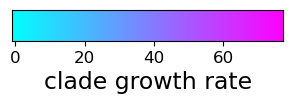

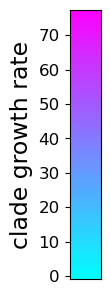

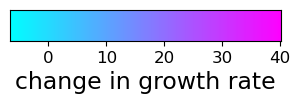

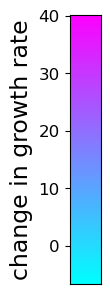

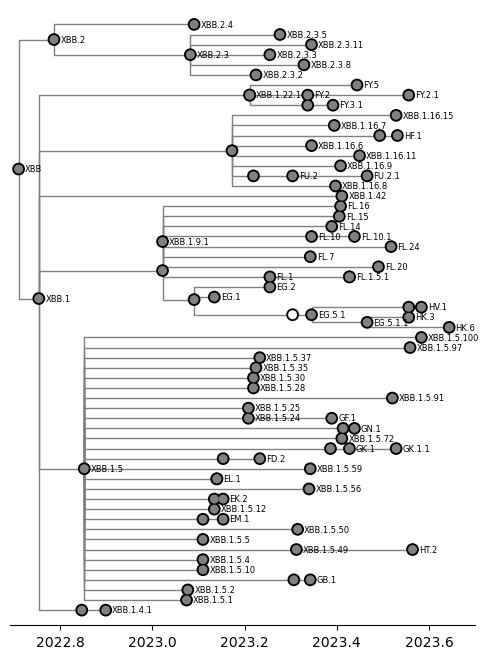

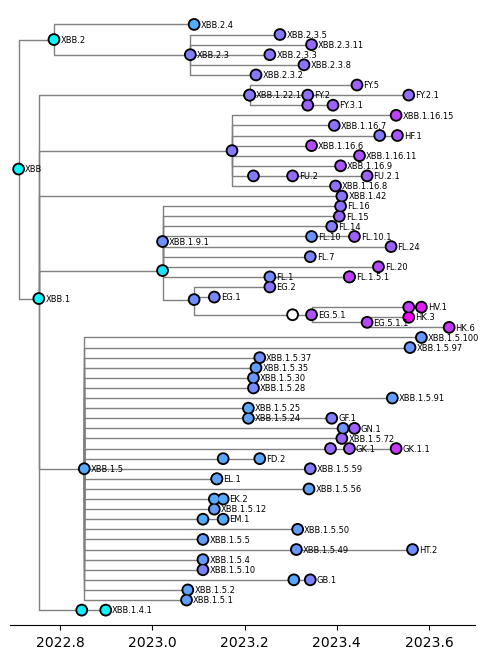

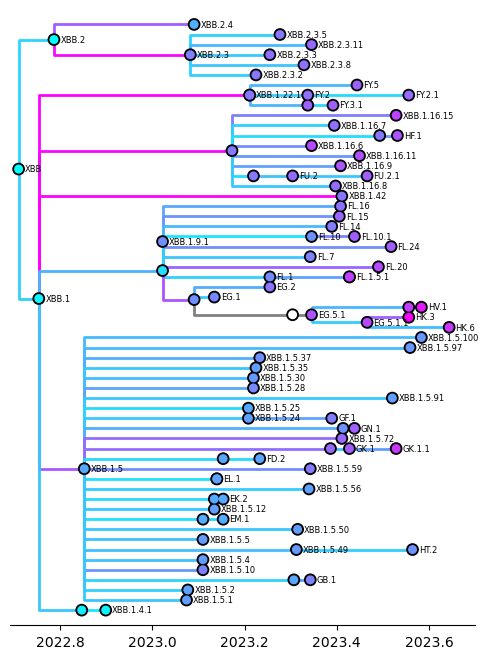

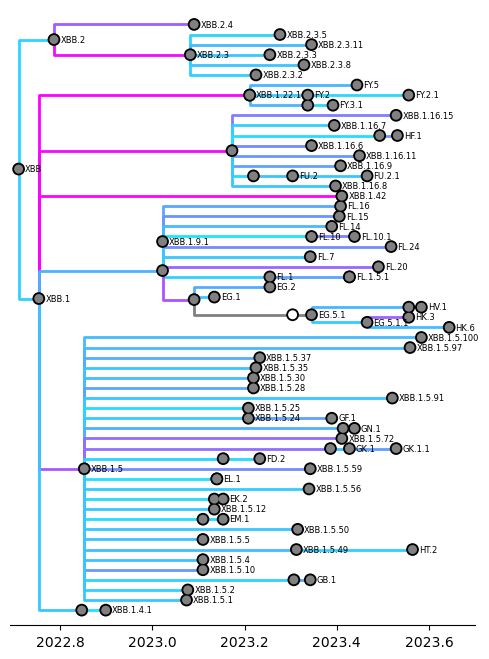

In [49]:
def build_clade(pango_name, parent_date):
    """Recursive function to build clades."""
    clade_datestr = pango_clades[pango_name]["designationDate"]
    clade_date = date_str_to_year(clade_datestr)
    assert clade_date >= parent_date
    # to make display better, we sort children so it is youngest, middle oldest, etc
    # first only keep clades that are not tips or are in set to keep. Note this code
    # is alll hacky just to get better clade layout for tree with less overlap
    children = [
        c
        for c in pango_clades[pango_name]["children"]
        if pango_clades[c]["children"] or c in clades_to_keep
    ]
    children_dates = [date_str_to_year(pango_clades[c]["designationDate"]) for c in children]
    children_by_date = list(reversed([c for _, c in sorted(zip(children_dates, children))]))
    nchildren = len(children_by_date)
    if nchildren % 2:
        children_sorted = [children_by_date[0]]
        children_by_date = children_by_date[1: ]
    else:
        children_sorted = []
    for i in range(nchildren // 2):
        children_sorted.append(children_by_date[i + nchildren // 2])
        children_sorted.append(children_by_date[i])
    assert set(children) == set(children_sorted) and len(children_sorted) == len(children), f"{children=}, {children_sorted=}"
    # sorting done, now build children into tree
    return Bio.Phylo.BaseTree.Clade(
        name=f"{pango_name}_{clade_datestr}",
        clades=[build_clade(c, clade_date) for c in children_sorted],
        branch_length=clade_date - parent_date,
    )

def date_str_to_year(date_str):
    dt = datetime.datetime.strptime(date_str, "%Y-%m-%d")
    # https://stackoverflow.com/a/29852163
    year_start = datetime.datetime(dt.year, 1, 1)
    year_end = year_start.replace(year=dt.year+1)
    return dt.year + ((dt - year_start).total_seconds() /  # seconds so far
        float((year_end - year_start).total_seconds()))  # seconds in year

for root_clade in starting_clades:
        print(f"Drawing clade for {root_clade}")

        clades_to_keep = set(pango_pair_dms_growth_df["clade"]).union(pango_pair_dms_growth_df["parent"])
    
        # first build a tree of all clades
        root_date = date_str_to_year(pango_clades[root_clade]["designationDate"])
        tree = Bio.Phylo.BaseTree.Tree(build_clade(root_clade, root_date))
        print(f"Starting tree has {len(tree.get_terminals())=} and {len(tree.get_nonterminals())=}")
    
        # now prune all non-terminal nodes without growth and DMS data, or ones without mutations
        # in the pairing with their parent
        removed = True
        while removed:
            for tip in tree.get_terminals():
                tipname = tip.name.split("_")[0]
                if tipname not in clades_to_keep:
                    parents = tree.get_path(tip)
                    if len(parents) == 1:
                        parent = tree.root
                    else:
                        parent = tree.get_path(tip)[-2]
                    assert tip in parent.clades
                    parent.clades = [c for c in parent.clades if c != tip]
                    break
            else:
                removed = False
        print(f"After pruning for tips with DMS and growth data, {len(tree.get_terminals())=} and {len(tree.get_nonterminals())=}")
    
        # read tree with `baltic`
        with tempfile.NamedTemporaryFile() as tf:
            Bio.Phylo.write(tree, tf.name, "newick")
            tf.flush()
            baltic_tree = baltic.loadNewick(
                tf.name,
                absoluteTime=True,
                tip_regex='_([0-9]+\-[0-9]+\-[0-9]+)',
                date_fmt='%Y-%m-%d',
                sortBranches=False,
            )
        # create tree with `sortBranches` as `False` then call it separately just by index to retain input
        # branch sorting
        baltic_tree.sortBranches(sort_function=lambda k: k.index)
    
        # map clade growth to colors
        clade_growth_dict = clade_growth_df.query("clade in @clades_to_keep").set_index("clade")["growth_rate"].to_dict()
        clade_colormap = dmslogo.colorschemes.ValueToColorMap(
            minvalue=min(clade_growth_dict.values()),
            maxvalue=max(clade_growth_dict.values()),
            cmap="cool",#cmap="viridis_r",
        )
        for orientation in ["horizontal", "vertical"]:
            fig, _ = clade_colormap.scale_bar(orientation=orientation, label="clade growth rate")
            display(fig)
            plt.close(fig)

        # map change in clade growht to colors
        pair_growth_change_dict = pango_pair_allmuts_growth_df.set_index("clade")["change_in_growth_rate"].to_dict()
        pair_colormap = dmslogo.colorschemes.ValueToColorMap(
            minvalue=min(pair_growth_change_dict.values()),
            maxvalue=max(pair_growth_change_dict.values()),
            cmap="cool",
        )
        for orientation in ["horizontal", "vertical"]:
            fig, _ = pair_colormap.scale_bar(orientation=orientation, label="change in growth rate")
            display(fig)
            plt.close(fig)
        
        # draw baltic tree 
        for node in baltic_tree.getExternal():
            node.traits["label"] = node.name.split("_")[0]
        for node in baltic_tree.getInternal():
            node.traits["label"] = node.traits["label"].split("_")[0]
        for coloring, node_colour, branch_colour, branch_width in [
            (
                "nocolor",
                lambda k: (
                    "gray"
                    if k.traits["label"] in clade_growth_dict
                    else "white"
                ),
                lambda k: "gray",
                1,
            ),
            (
                "color-nodes",
                lambda k: (
                    clade_colormap.val_to_color(clade_growth_dict[k.traits["label"]])
                    if k.traits["label"] in clade_growth_dict
                    else "white"
                ),
                lambda k: "gray",
                1,
            ),
            (
                "color-nodes-and-branches",
                lambda k: (
                    clade_colormap.val_to_color(clade_growth_dict[k.traits["label"]])
                    if k.traits["label"] in clade_growth_dict
                    else "white"
                ),
                lambda k: (
                    pair_colormap.val_to_color(pair_growth_change_dict[k.traits["label"]])
                    if k.traits["label"] in pair_growth_change_dict
                    else "gray"
                ),
                2,
            ),
            (
                "color-branches",
                lambda k: (
                    "gray"
                    if k.traits["label"] in clade_growth_dict
                    else "white"
                ),
                lambda k: (
                    pair_colormap.val_to_color(pair_growth_change_dict[k.traits["label"]])
                    if k.traits["label"] in pair_growth_change_dict
                    else "gray"
                ),
                2,
            ),
        ]:
            fig, ax = plt.subplots(figsize=(6, 8), facecolor="w")   
            baltic_tree.plotTree(
                ax,
                x_attr=lambda k: k.absoluteTime,
                width=branch_width,
                colour=branch_colour,
                alpha=1,
                connection_type="elbow",
            )
            baltic_tree.plotPoints(
                ax,
                x_attr=lambda k: k.absoluteTime,
                size=42,
                target=lambda k: True,
                colour=node_colour,
                outline_colour="black",
            )
            baltic_tree.addText(
                ax,
                x_attr=lambda k: k.absoluteTime + baltic_tree.treeHeight * 0.015,
                # label tips and internal branches that aren't too short (to avoid overlap we don't label short ones)
                text=lambda k: (
                    k.traits["label"]
                    if (k.branchType == "leaf" or k.traits["label"] == root_clade or min(c.length for c in k.children) > 0.09)
                    else ""
                ),
                target=lambda k: True,
                verticalalignment="center",
                fontsize=6,
                fontdict={},
            )
        
            _ = ax.set_ylim(-1, baltic_tree.ySpan + 1)
            _ = ax.set_xlim(root_date - baltic_tree.treeHeight * 0.02, root_date + baltic_tree.treeHeight * 1.06)
            ax.set_yticks([])
            ax.set_yticklabels([])
            [ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
    
            # plot with nodes and branches colored
            display(fig)
            plt.close(fig)
